**Project**: Submarine Route Constraints  
**Author**: Alejandra L. Cameselle  
**Date**: July 2025  
**Notebook**: 03 – Assign Depth and Priority to Rocky Outcrops

### Description
This notebook extracts depth values for each polygon in the `rocky_outcrops` layer using a bathymetric raster and classifies each feature based on a depth threshold. Features shallower than 1000 m are marked as high priority to avoid due to burial infeasibility.

### Inputs
- `inputs/rocky_outcrops.gpkg`: Original rocky outcrops (no attributes)
- `inputs/bathymetry_clipped.tiff`: Bathymetry raster clipped to AOI

### Processing
- Read and reproject both layers to EPSG:25829
- Extract mean depth from raster for each rocky outcrop polygon
- Classify each outcrop as:
  - `High` priority if depth < 1000 m
  - `Medium` priority otherwise
- Save result with new attribute `priority_class`

### Outputs
- `processed_data/rocky_outcrops_depth.gpkg`: Rocky outcrops with depth and priority

### Assumptions
- Bathymetry raster and rocky outcrop layer are fully overlapping and correctly aligned in projection
- Rocky outcrop depth is represented by the mean raster value within each polygon

### Dependencies
- geopandas, rasterstats, rasterio, numpy, matplotlib, seaborn

In [1]:
# Load libraries
import geopandas as gpd
import rasterio
from rasterio import features
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import shape
import os

### Step 1: Create depth mask (<1000m) from bathymetry raster


In [2]:
# Load bathymetry raster
raster_path = "../inputs/bathymetry_clipped.tif"
with rasterio.open(raster_path) as src:
    bathy = src.read(1)
    affine = src.transform
    crs = src.crs

In [3]:
# Convert depth to positive values (assumes negative depth)
depth = abs(bathy)

In [4]:
# Create binary mask: 1 = shallow (<1000m), 0 = deep (>=1000m)
shallow_mask = (depth < 1000).astype("uint8")

In [5]:
# Convert raster to polygons
shapes = features.shapes(shallow_mask, transform=affine)
polygons = [shape(geom) for geom, val in shapes if val == 1]
shallow_gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
shallow_gdf["depth_zone"] = "shallow"

In [6]:
# Save for reference
os.makedirs("../processed_data/masks", exist_ok=True)
shallow_gdf.to_file("../processed_data/masks/03_shallow_zone_mask.gpkg", driver="GPKG")

### Step 2: Assign conditional priority to rocky_outcrops


In [7]:
rocky = gpd.read_file("../processed_data/constraints/rocky_outcrops_clipped.gpkg")

In [8]:
# Spatial join with shallow zones
rocky["depth_zone"] = "deep"  # default
rocky = rocky.sjoin(shallow_gdf, how="left", predicate="intersects")
rocky.loc[rocky["depth_zone_right"] == "shallow", "depth_zone"] = "shallow"

In [9]:
# Assign priority
rocky["depth_category"] = rocky["depth_zone"].map({"shallow": "shallow", "deep": "deep"})
rocky.drop(columns=["index_right", "depth_zone_right"], inplace=True)

In [10]:
# Save updated layer
rocky.to_file("../processed_data/03_rocky_outcrops_clipped_depth.gpkg", driver="GPKG")

Plot saved to: ../outputs/plots/03_rocky_outcrops_depth_category.png


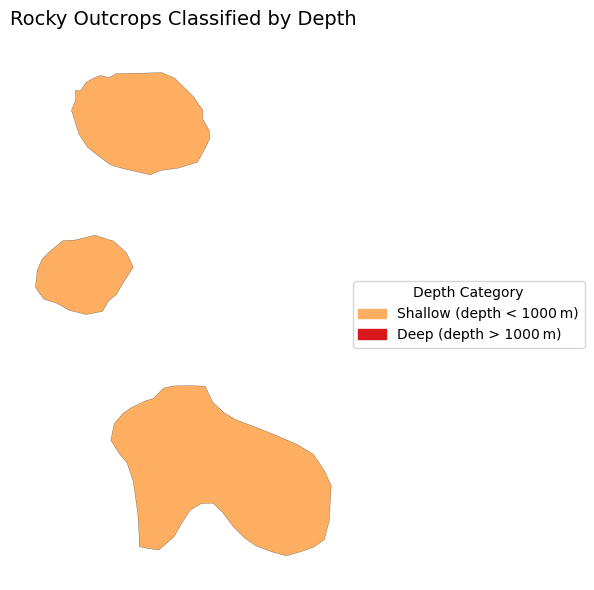

In [11]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Define color mapping and labels
color_map = {'shallow': "#fdae61", 'deep': "#d7191c"}
labels_map = {
    'shallow': "Shallow (depth < 1000 m)",
    'deep': "Deep (depth > 1000 m)"
}
custom_order = ['shallow', 'deep']

# Assign color to each geometry
rocky["color"] = rocky["depth_category"].map(color_map)

# Plot geometries
rocky.plot(color=rocky["color"], edgecolor="black", linewidth=0.15, ax=ax)

# Manual legend
handles = [mpatches.Patch(color=color_map[key], label=labels_map[key]) for key in custom_order]
ax.legend(
    handles=handles,
    title="Depth Category",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# Final layout
ax.set_title("Rocky Outcrops Classified by Depth", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# Save plot to file
os.makedirs("../outputs/plots", exist_ok=True)
output_path = "../outputs/plots/03_rocky_outcrops_depth_category.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"Plot saved to: {output_path}")

# Show plot
plt.show()